In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2
using DSP
using PythonPlot
mpl = PythonPlot.pyimport("matplotlib")
mpl.rcParams["svg.fonttype"] = "none"

"none"

In [2]:
function setup(r) # r specifies radius of simulated spherical cell
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,6)
    r0[:,:,1] .= 5 .*(rand.())   # Cdc42-GTPm
    #r0[50,50,1] = 500 # optionally seed polarity sites
    r0[:,:,2] .= 0.5 - mean(r0[:,:,1])*n   # Cdc42-GDPm should be 0.5
    r0[:,:,3] .= 1
    r0[:,:,4] .= 10 .*(rand.())
    r0[:,:,5] .= 1
    r0[:,:,6] .= 0.5 # 0.75
    
    # Dummy parameters used to prevent reallocation on each fxn call
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    Dgef = zeros(N,N)
    Dpakc = zeros(N,N)
    Dgefc = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R)
    # Actual parameters
    a = .8
    b = .07*1.25
    c = 1
    d = .03 
    e = .04 
    f = .05 
    g = .025 * 1.25
    Dm = .01
    Dc = 10
    Dm2 = .1
    n = n

    p = (a, b, c, d, e, f, g, Dm, Dc, Dm2, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [3]:
function negativeFB!(dr,r,p,t)
    a, b, c, d, e, f, g, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    gef = @view r[:,:,4]
    pakc = @view r[:,:,5]
    gefc = @view r[:,:,6]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    mul!(Ayt,Ay,gef)
    mul!(tAx,gef,Ax)
    @. Dgef = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,pakc)
    mul!(tAx,pakc,Ax)
    @. Dpakc = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,gefc)
    mul!(tAx,gefc,Ax)
    @. Dgefc = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*gef^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = d*rhoT*pakc - e*pak + Dpak
    @. dr[:,:,4] = f*rhoT*gefc - g*pak*gef + Dgef 
    @. dr[:,:,5] = n*(- d*rhoT*pakc + e*pak) + Dpakc
    @. dr[:,:,6] = n*(- f*rhoT*gefc + g*pak*gef) + Dgefc
end


negativeFB! (generic function with 1 method)

In [27]:
function run_pde(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(negativeFB!,r0,(0.0,3600),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES), abstol = 5e-9, reltol = 5e-6, saveat=1)
    return sol_simp
end

run_pde (generic function with 1 method)

In [28]:
Random.seed!(1)
sol3 = run_pde(3)

retcode: MaxIters
Interpolation: 1st order linear
t: 3450-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3441.0
 3442.0
 3443.0
 3444.0
 3445.0
 3446.0
 3447.0
 3448.0
 3448.7829863402944
u: 3450-element Vector{Array{Float64, 3}}:
 [0.36683177234646425 0.835264546438933 … 2.249147211554762 2.173323933861879; 1.7462074477859306 3.5986034627025916 … 4.042108624872047 4.622203430755562; … ; 4.169267240766527 1.8065761920519257 … 1.647577563964819 2.9521148392176446; 4.908521739743653 1.8093785356895964 … 1.5532595482954692 1.13008217989294;;; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491; … ; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.

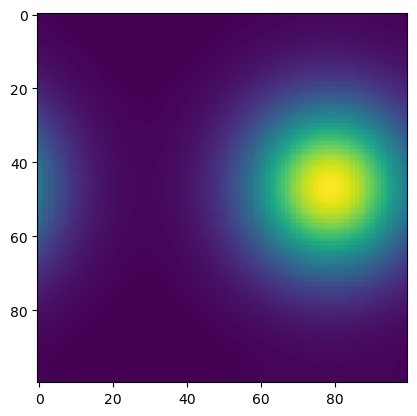

In [10]:
imshow(sol3[:,:,1,end])
display(gcf())

In [32]:
seed = 1
radius= 3
@save "../sims/negFB_r$(radius)_seed$(seed)_tol5x.jld2" sol3

In [10]:
Random.seed!(3)
sol5 = run_pde(5)

retcode: Success
Interpolation: 1st order linear
t: 3601-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3592.0
 3593.0
 3594.0
 3595.0
 3596.0
 3597.0
 3598.0
 3599.0
 3600.0
u: 3601-element Vector{Array{Float64, 3}}:
 [1.6986739459507139 4.4220385254977055 … 4.303168578345623 1.2684746352934029; 4.796164489844406 2.343212185651795 … 2.0883653853306097 3.13287896640823; … ; 3.611423155519292 1.357503299383962 … 2.0817774312499253 1.9170584328130846; 0.910105885423983 0.6810856799394083 … 0.7626353560342519 2.465122406811902;;; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265; … ; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0

In [18]:
Random.seed!(1)
sol9 = run_pde(9)

retcode: Success
Interpolation: 1st order linear
t: 3601-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3592.0
 3593.0
 3594.0
 3595.0
 3596.0
 3597.0
 3598.0
 3599.0
 3600.0
u: 3601-element Vector{Array{Float64, 3}}:
 [0.36683177234646425 0.835264546438933 … 2.249147211554762 2.173323933861879; 1.7462074477859306 3.5986034627025916 … 4.042108624872047 4.622203430755562; … ; 4.169267240766527 1.8065761920519257 … 1.647577563964819 2.9521148392176446; 4.908521739743653 1.8093785356895964 … 1.5532595482954692 1.13008217989294;;; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; … ; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;

In [ ]:
# These take a long time to simulate. Best to save result.
seed = 1
radius= 3
@save "../sims/negFB_r$(radius)_seed$(seed).jld2" sol3
seed = 3
radius= 5
@save "../sims/negFB_r$(radius)_seed$(seed).jld2" sol5
seed = 1
radius= 9
@save "../sims/negFB_r$(radius)_seed$(seed).jld2" sol9

In [5]:
sol3 = load("../sims/negFB_r3_seed1.jld2", "sol3")
sol5 = load("../sims/negFB_r5_seed3.jld2", "sol5")
sol9 = load("../sims/negFB_r9_seed1.jld2", "sol9")

┌ Warning: type Base.RefValue{SciMLBase.Void{Main.#simple!}} does not exist in workspace; reconstructing
└ @ JLD2 /home/dinosaur/.julia/packages/JLD2/ifXF8/src/data/reconstructing_datatypes.jl:492
┌ Warning: type Base.RefValue{SciMLBase.Void{Main.#simple!}} does not exist in workspace; reconstructing
└ @ JLD2 /home/dinosaur/.julia/packages/JLD2/ifXF8/src/data/reconstructing_datatypes.jl:492
┌ Warning: type Base.RefValue{SciMLBase.Void{Main.#simple!}} does not exist in workspace; reconstructing
└ @ JLD2 /home/dinosaur/.julia/packages/JLD2/ifXF8/src/data/reconstructing_datatypes.jl:492


retcode: Success
Interpolation: 1st order linear
t: 3601-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3592.0
 3593.0
 3594.0
 3595.0
 3596.0
 3597.0
 3598.0
 3599.0
 3600.0
u: 3601-element Vector{Array{Float64, 3}}:
 [0.36683177234646425 0.835264546438933 … 2.249147211554762 2.173323933861879; 1.7462074477859306 3.5986034627025916 … 4.042108624872047 4.622203430755562; … ; 4.169267240766527 1.8065761920519257 … 1.647577563964819 2.9521148392176446; 4.908521739743653 1.8093785356895964 … 1.5532595482954692 1.13008217989294;;; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; … ; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;

In [13]:
function mask_site(sim, threshold; n_sites=1)
    im_array = sim
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [14]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

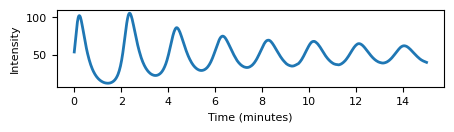

In [29]:
interval = 1
cov_threshold=0.3
time_threshold=.5
masks = mask_site(sol3[:,:,1,:], cov_threshold, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = maximum(m1, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
crop1 = q1[times_max1]
t = range(0,60*15)*(1/60) # Convert from 1 frame every 5 sec, to minutes

fig, ax = subplots(figsize=(5,1))
ax.plot(t, crop1, linewidth=2, color="C0")
ax.set_ylabel("Intensity", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

#PythonPlot.savefig("../figures/sol3_trace.svg")
display(gcf())

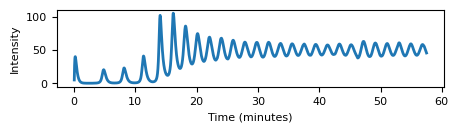

In [31]:
fig, ax = subplots(figsize=(5,1))
ax.plot(1/60:1/60:length(q1)./60, q1, linewidth=2, color="C0")
ax.set_ylabel("Intensity", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
PythonPlot.savefig("../figures/sol3_fulltrace-tol5x.svg", transparent=true)
display(gcf())

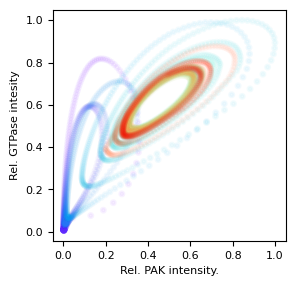

In [62]:
fig, ax = subplots(figsize=(3,3))
T = maximum(mask_site(sol3[:,:,1,:], cov_threshold, n_sites=1), dims=(1,2))[1,1,:,1]
T = T ./ maximum(T)
P = maximum(mask_site(sol3[:,:,3,:], cov_threshold, n_sites=1), dims=(1,2))[1,1,:,1]
P = P ./ maximum(P)
colors = 1:length(T)
ax.scatter(T, P, linewidth=2, alpha=0.05, marker=".", c=colors, cmap="rainbow")
ax.set_ylabel("Rel. GTPase intesity", fontsize=8)
ax.set_xlabel("Rel. PAK intensity.", fontsize=8)
ax.tick_params(labelsize=8)
#PythonPlot.savefig("../figures/sol3_limitcycle.svg", transparent=true)
display(gcf())

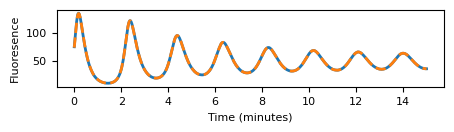

In [14]:
interval = 1
cov_threshold=0.3
time_threshold=.5
masks = mask_site(sol5[:,:,1,:], cov_threshold, n_sites=2);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
m2 = masks[:,:,:,2]
q1 = maximum(m1, dims=(1,2))[1,1,:]
q2 = maximum(m2, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60*15)*(1/60) # Convert from 1 frame every 5 sec, to minutes

fig, ax = subplots(figsize=(5,1))
ax.plot(t, crop1, linewidth=2, color="C0", alpha=1)
ax.plot(t, crop2, linewidth=2, color="C1", alpha=1, linestyle="--")
ax.set_ylabel("Fluoresence", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

#PythonPlot.savefig("../figures/sol5_trace.svg", transparent=true)
display(gcf())


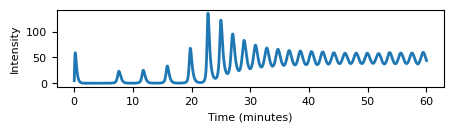

In [15]:
fig, ax = subplots(figsize=(5,1))
ax.plot(1/60:1/60:length(q1)./60, q1, linewidth=2, color="C0")
#ax.plot(1/60:1/60:length(q1)./60, q2, linewidth=2, color="C1", linestyle="--")
ax.set_ylabel("Intensity", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
PythonPlot.savefig("../figures/sol5_fulltrace-1patch.svg", transparent=true)
display(gcf())

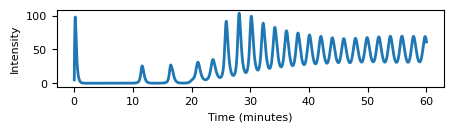

In [16]:
interval = 1
cov_threshold=0.3
time_threshold=.9
masks = mask_site(sol9[:,:,1,:], cov_threshold, n_sites=7);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
t = range(0,60*15)*(1/60) # Convert from 1 frame every 5 sec, to minutes

fig, ax = subplots(figsize=(5,1))
for i in 1
    m = masks[:,:,:,i]
    q = maximum(m, dims=(1,2))[1,1,:]
    #times_max = crop_times(q, 15*(60/interval), time_threshold)
    #crop = q[times_max]
    ax.plot(1/60:1/60:length(q1)./60, q, linewidth=2,alpha=1)
    ax.set_ylabel("Intensity", fontsize=8)
    ax.set_xlabel("Time (minutes)", fontsize=8)
    ax.tick_params(labelsize=8)
end

PythonPlot.savefig("../figures/sol9_fulltrace-1patch.svg", transparent=true)
display(gcf())

In [49]:
for i in 10:1/2:35
    r = 3
    fig, ax = subplots(figsize=(0.8,0.8))
    ax.imshow(sol3[:,:,1,Int(round(i*60))], clim=(0,100), cmap="inferno")
    ax.set_axis_off()
    ax.hlines(95 ,xmin=5, xmax=5+(100/3)*1, color="white")
    min = Int(trunc(i))
    sec = Int(mod(i,min)*60)
    if sec == 0
        sec = "00"
    end
    ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
    PythonPlot.savefig("../figures/r3/sim_r$(r)_t$(i).png", transparent=true)
end
    

In [ ]:
for i in 20:1/2:35
    r = 5
    fig, ax = subplots(figsize=(0.8,0.8))
    ax.imshow(sol5[:,:,1,Int(round(i*60))], clim=(0,100), cmap="inferno")
    ax.set_axis_off()
    ax.hlines(95 ,xmin=5, xmax=5+(100/5)*1, color="white")
    min = Int(trunc(i))
    sec = Int(mod(i,min)*60)
    if sec == 0
        sec = "00"
    end
    ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
    PythonPlot.savefig("../figures/r5/sim_r$(r)_t$(i).png", transparent=true)
end
    

In [44]:
for i in 30:1/2:40
    r = 9
    fig, ax = subplots(figsize=(0.8,0.8))
    ax.imshow(sol9[:,:,1,Int(round(i*60))], clim=(0,100), cmap="inferno")
    ax.set_axis_off()
    ax.hlines(95 ,xmin=5, xmax=5+(100/9)*1, color="white")
    min = Int(trunc(i))
    sec = Int(mod(i,min)*60)
    if sec == 0
        sec = "00"
    end
    ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
    PythonPlot.savefig("../figures/r9/sim_r$(r)_t$(i).svg", transparent=true)
end
    

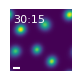

Python: None

In [33]:
tmpt = 30 + 1/4
fig, ax = subplots(figsize=(0.8,0.8))
ax.imshow(sol9[:,:,1,Int(round(30*60))])
ax.hlines(95 ,xmin=5, xmax=5+(100/9)*1, color="white")
min = Int(round(30.5))
sec = Int(mod(tmpt, 30)*60)
ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
ax.set_axis_off()
display(gcf())
PythonPlot.savefig("../figures/test.svg", transparent=true)

In [31]:
Int(mod(tmpt, 30)*60)

30

In [42]:
Int(trunc(30.8))

30